In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 134)
(4721, 13953)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 134)
(334, 13953)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
# train_input = (train_input - np.reshape(np.mean(train_input, 1), (train_input.shape[0], 1)))/np.reshape(np.std(train_input, 1), (train_input.shape[0], 1))
# val_input = (val_input - np.reshape(np.mean(val_input, 1), (val_input.shape[0], 1)))/np.reshape(np.std(val_input, 1), (val_input.shape[0], 1))
# test_input = (test_input - np.reshape(np.mean(test_input, 1), (test_input.shape[0], 1)))/np.reshape(np.std(test_input, 1), (test_input.shape[0], 1))

In [25]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [26]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [27]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [28]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [31]:
batch_train = batch_train + batch_val

In [32]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([66175, 1])

In [33]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([28921, 1])

In [34]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [35]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [36]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [37]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [38]:
PATH = 'No_norm_model_pro_RNA'

In [39]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (13, 3*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.21714546  Validation_loss:  0.10474726  Test_loss:  0.18998687


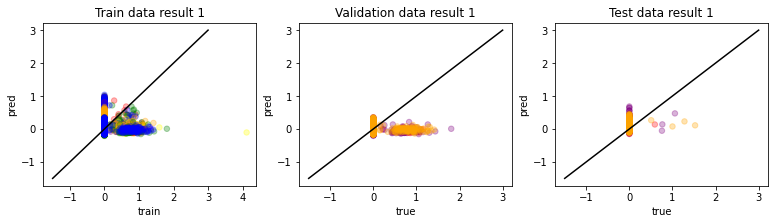

Epoch  100 Train_loss:  0.115873195  Validation_loss:  0.10923656  Test_loss:  0.13354826
Epoch  200 Train_loss:  0.10381167  Validation_loss:  0.09541506  Test_loss:  0.12420851
Epoch  300 Train_loss:  0.09720883  Validation_loss:  0.08877875  Test_loss:  0.11555467
Epoch  400 Train_loss:  0.09246276  Validation_loss:  0.08443624  Test_loss:  0.10785761
Epoch  500 Train_loss:  0.088687025  Validation_loss:  0.0812719  Test_loss:  0.101636074
Epoch  600 Train_loss:  0.08567178  Validation_loss:  0.07892429  Test_loss:  0.09704177
Epoch  700 Train_loss:  0.08333583  Validation_loss:  0.077267155  Test_loss:  0.0939343
Epoch  800 Train_loss:  0.08163854  Validation_loss:  0.07619179  Test_loss:  0.09201197
Epoch  900 Train_loss:  0.08042176  Validation_loss:  0.07551784  Test_loss:  0.09083168
Epoch  1000 Train_loss:  0.07952548  Validation_loss:  0.07509281  Test_loss:  0.09014214


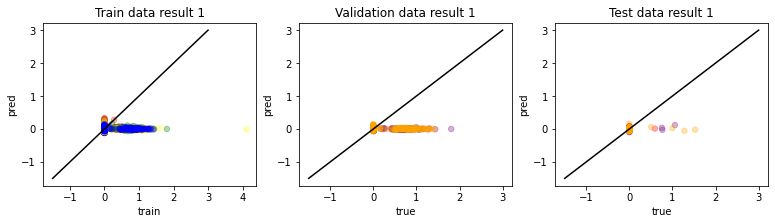

Epoch  1100 Train_loss:  0.078842856  Validation_loss:  0.07480289  Test_loss:  0.089710616
Epoch  1200 Train_loss:  0.07831061  Validation_loss:  0.074599296  Test_loss:  0.08942453
Epoch  1300 Train_loss:  0.07788438  Validation_loss:  0.074445024  Test_loss:  0.089221895
Epoch  1400 Train_loss:  0.07753213  Validation_loss:  0.07431975  Test_loss:  0.08907265
Epoch  1500 Train_loss:  0.07723641  Validation_loss:  0.0742188  Test_loss:  0.088953495
Epoch  1600 Train_loss:  0.07698269  Validation_loss:  0.07413443  Test_loss:  0.08884815
Epoch  1700 Train_loss:  0.07676288  Validation_loss:  0.07406135  Test_loss:  0.088750735
Epoch  1800 Train_loss:  0.07657142  Validation_loss:  0.07399739  Test_loss:  0.088667154
Epoch  1900 Train_loss:  0.07640802  Validation_loss:  0.07394273  Test_loss:  0.08859179
Epoch  2000 Train_loss:  0.07626337  Validation_loss:  0.07389449  Test_loss:  0.088523164


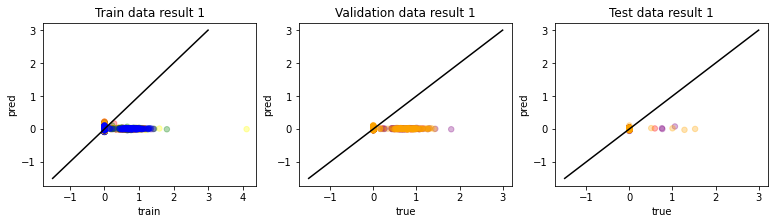

Epoch  2100 Train_loss:  0.07613409  Validation_loss:  0.07385134  Test_loss:  0.088462666
Epoch  2200 Train_loss:  0.07602036  Validation_loss:  0.07381334  Test_loss:  0.08840785
Epoch  2300 Train_loss:  0.075918496  Validation_loss:  0.073779404  Test_loss:  0.08836054
Epoch  2400 Train_loss:  0.0758263  Validation_loss:  0.07374819  Test_loss:  0.08833702
Epoch  2500 Train_loss:  0.075743206  Validation_loss:  0.073720016  Test_loss:  0.08831545
Epoch  2600 Train_loss:  0.07566799  Validation_loss:  0.073694736  Test_loss:  0.08829852
Epoch  2700 Train_loss:  0.07559957  Validation_loss:  0.07367092  Test_loss:  0.088283546
Epoch  2800 Train_loss:  0.07553721  Validation_loss:  0.073649146  Test_loss:  0.0882688
Epoch  2900 Train_loss:  0.075481504  Validation_loss:  0.07362979  Test_loss:  0.088255405
Epoch  3000 Train_loss:  0.075430036  Validation_loss:  0.07361083  Test_loss:  0.08824422


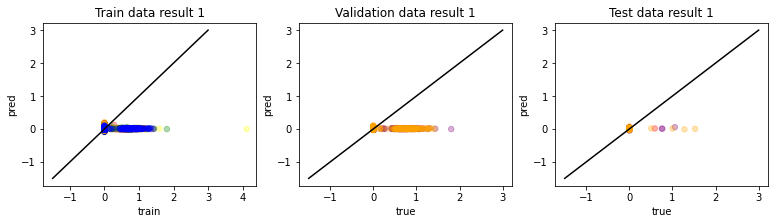

Epoch  3100 Train_loss:  0.07538357  Validation_loss:  0.07359355  Test_loss:  0.088243
Epoch  3200 Train_loss:  0.07534009  Validation_loss:  0.07357697  Test_loss:  0.08824189
Epoch  3300 Train_loss:  0.07530003  Validation_loss:  0.07356211  Test_loss:  0.088240474
Epoch  3400 Train_loss:  0.075263575  Validation_loss:  0.073548205  Test_loss:  0.088241555
Epoch  3500 Train_loss:  0.07522941  Validation_loss:  0.073534876  Test_loss:  0.08824095
Epoch  3600 Train_loss:  0.075198025  Validation_loss:  0.07352217  Test_loss:  0.08824256
Epoch  3700 Train_loss:  0.07516855  Validation_loss:  0.073510505  Test_loss:  0.088244446
Epoch  3800 Train_loss:  0.07514135  Validation_loss:  0.073499285  Test_loss:  0.088245384
Epoch  3900 Train_loss:  0.075115904  Validation_loss:  0.07348851  Test_loss:  0.08824637
Epoch  4000 Train_loss:  0.07509231  Validation_loss:  0.073479004  Test_loss:  0.088248014


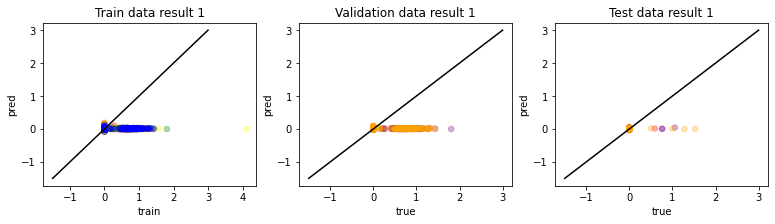

Epoch  4100 Train_loss:  0.07507003  Validation_loss:  0.0734694  Test_loss:  0.088248156
Epoch  4200 Train_loss:  0.07504892  Validation_loss:  0.07345997  Test_loss:  0.088248655
Epoch  4300 Train_loss:  0.07502954  Validation_loss:  0.073451705  Test_loss:  0.08825127
Epoch  4400 Train_loss:  0.07501096  Validation_loss:  0.07344335  Test_loss:  0.08825171
Epoch  4500 Train_loss:  0.07499341  Validation_loss:  0.073435396  Test_loss:  0.08825372
Epoch  4600 Train_loss:  0.074977  Validation_loss:  0.073428385  Test_loss:  0.08825416
Epoch  4700 Train_loss:  0.07496148  Validation_loss:  0.073421136  Test_loss:  0.088256456
Epoch  4800 Train_loss:  0.07494682  Validation_loss:  0.073414266  Test_loss:  0.088259056
Epoch  4900 Train_loss:  0.07493304  Validation_loss:  0.07340768  Test_loss:  0.088261046
Epoch  5000 Train_loss:  0.07491993  Validation_loss:  0.07340174  Test_loss:  0.088262424


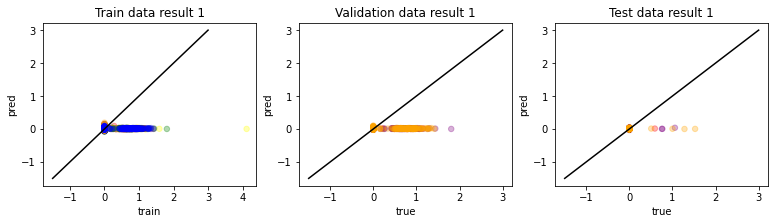

Epoch  5100 Train_loss:  0.07490739  Validation_loss:  0.07339564  Test_loss:  0.08826354
Epoch  5200 Train_loss:  0.07489563  Validation_loss:  0.07339015  Test_loss:  0.08826486
Epoch  5300 Train_loss:  0.07488444  Validation_loss:  0.07338479  Test_loss:  0.088266864
Epoch  5400 Train_loss:  0.07487388  Validation_loss:  0.07337936  Test_loss:  0.08826931
Epoch  5500 Train_loss:  0.0748639  Validation_loss:  0.07337472  Test_loss:  0.08826917
Epoch  5600 Train_loss:  0.07485423  Validation_loss:  0.073370025  Test_loss:  0.088271156
Epoch  5700 Train_loss:  0.074845046  Validation_loss:  0.07336528  Test_loss:  0.088273324
Epoch  5800 Train_loss:  0.07483638  Validation_loss:  0.07336139  Test_loss:  0.08827529
Epoch  5900 Train_loss:  0.07482804  Validation_loss:  0.07335712  Test_loss:  0.0882804
Epoch  6000 Train_loss:  0.07482014  Validation_loss:  0.073353484  Test_loss:  0.08828654


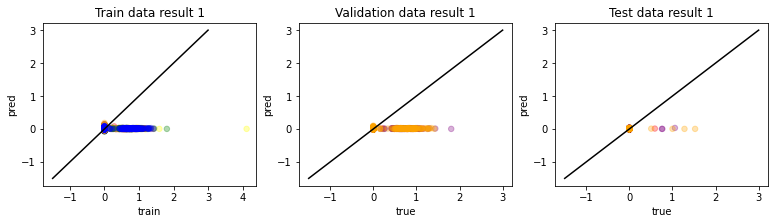

Epoch  6100 Train_loss:  0.07481276  Validation_loss:  0.07334942  Test_loss:  0.08829216
Epoch  6200 Train_loss:  0.07480564  Validation_loss:  0.07334569  Test_loss:  0.08829727
Epoch  6300 Train_loss:  0.0747987  Validation_loss:  0.073341444  Test_loss:  0.08830283
Epoch  6400 Train_loss:  0.07479213  Validation_loss:  0.073338464  Test_loss:  0.0883099
Epoch  6500 Train_loss:  0.074785724  Validation_loss:  0.07333508  Test_loss:  0.0883146
Epoch  6600 Train_loss:  0.074779525  Validation_loss:  0.07333193  Test_loss:  0.088320084
Epoch  6700 Train_loss:  0.074773625  Validation_loss:  0.0733286  Test_loss:  0.08832548
Epoch  6800 Train_loss:  0.07476786  Validation_loss:  0.07332559  Test_loss:  0.088330075
Epoch  6900 Train_loss:  0.074762285  Validation_loss:  0.07332245  Test_loss:  0.08833551
Epoch  7000 Train_loss:  0.07475695  Validation_loss:  0.073319346  Test_loss:  0.088340044


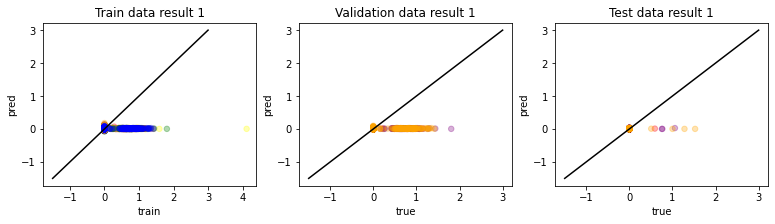

Epoch  7100 Train_loss:  0.07475185  Validation_loss:  0.0733167  Test_loss:  0.08834409
Epoch  7200 Train_loss:  0.074746914  Validation_loss:  0.07331397  Test_loss:  0.088347904
Epoch  7300 Train_loss:  0.074742176  Validation_loss:  0.07331199  Test_loss:  0.08835281
Epoch  7400 Train_loss:  0.07473749  Validation_loss:  0.07330863  Test_loss:  0.08835588
Epoch  7500 Train_loss:  0.07473301  Validation_loss:  0.07330608  Test_loss:  0.08836049
Epoch  7600 Train_loss:  0.07472869  Validation_loss:  0.07330417  Test_loss:  0.08836411
Epoch  7700 Train_loss:  0.07472449  Validation_loss:  0.07330168  Test_loss:  0.088367835
Epoch  7800 Train_loss:  0.07472044  Validation_loss:  0.07329917  Test_loss:  0.08837231
Epoch  7900 Train_loss:  0.07471638  Validation_loss:  0.07329689  Test_loss:  0.08837579
Epoch  8000 Train_loss:  0.07471254  Validation_loss:  0.07329504  Test_loss:  0.08837877


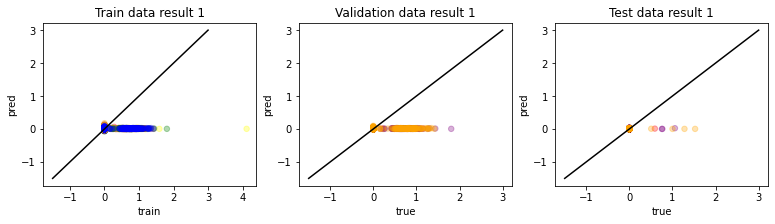

Epoch  8100 Train_loss:  0.07470878  Validation_loss:  0.073292546  Test_loss:  0.08838221
Epoch  8200 Train_loss:  0.07470518  Validation_loss:  0.07329015  Test_loss:  0.08838569
Epoch  8300 Train_loss:  0.07470165  Validation_loss:  0.07328847  Test_loss:  0.08839003
Epoch  8400 Train_loss:  0.07469821  Validation_loss:  0.07328631  Test_loss:  0.088393405
Epoch  8500 Train_loss:  0.07469483  Validation_loss:  0.073284455  Test_loss:  0.088396475
Epoch  8600 Train_loss:  0.07469152  Validation_loss:  0.0732824  Test_loss:  0.08840068
Epoch  8700 Train_loss:  0.074688375  Validation_loss:  0.073280804  Test_loss:  0.08840341
Epoch  8800 Train_loss:  0.07468527  Validation_loss:  0.07327879  Test_loss:  0.08840706
Epoch  8900 Train_loss:  0.07468223  Validation_loss:  0.073277585  Test_loss:  0.08840953
Epoch  9000 Train_loss:  0.0746792  Validation_loss:  0.07327567  Test_loss:  0.0884139


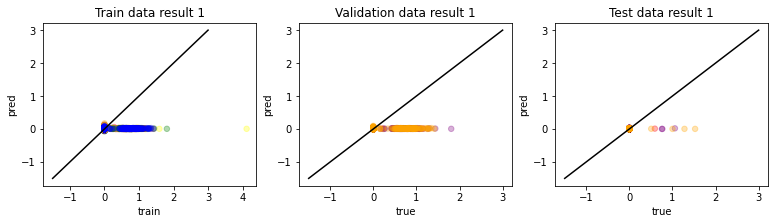

Epoch  9100 Train_loss:  0.07467632  Validation_loss:  0.07327424  Test_loss:  0.08841646
Epoch  9200 Train_loss:  0.074673474  Validation_loss:  0.073272295  Test_loss:  0.088419996
Epoch  9300 Train_loss:  0.07467069  Validation_loss:  0.073270716  Test_loss:  0.088423535
Epoch  9400 Train_loss:  0.07466792  Validation_loss:  0.07326877  Test_loss:  0.08842627
Epoch  9500 Train_loss:  0.07466525  Validation_loss:  0.07326743  Test_loss:  0.08842893
Epoch  9600 Train_loss:  0.07466259  Validation_loss:  0.07326631  Test_loss:  0.08843244
Epoch  9700 Train_loss:  0.07466  Validation_loss:  0.07326461  Test_loss:  0.08843562
Epoch  9800 Train_loss:  0.07465747  Validation_loss:  0.07326267  Test_loss:  0.08843961
Epoch  9900 Train_loss:  0.07465493  Validation_loss:  0.07326129  Test_loss:  0.08844254
Epoch  10000 Train_loss:  0.07465246  Validation_loss:  0.07325994  Test_loss:  0.08844624


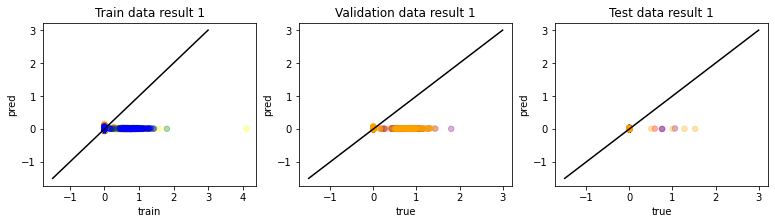

Epoch  10100 Train_loss:  0.07465004  Validation_loss:  0.073258385  Test_loss:  0.088448726
Epoch  10200 Train_loss:  0.07464772  Validation_loss:  0.0732572  Test_loss:  0.088453144
Epoch  10300 Train_loss:  0.07464544  Validation_loss:  0.07325562  Test_loss:  0.08845558
Epoch  10400 Train_loss:  0.07464317  Validation_loss:  0.07325496  Test_loss:  0.08845821
Epoch  10500 Train_loss:  0.0746409  Validation_loss:  0.07325331  Test_loss:  0.08846273
Epoch  10600 Train_loss:  0.07463872  Validation_loss:  0.073252305  Test_loss:  0.0884646
Epoch  10700 Train_loss:  0.074636556  Validation_loss:  0.07325097  Test_loss:  0.08846778
Epoch  10800 Train_loss:  0.074634336  Validation_loss:  0.073250264  Test_loss:  0.08846954
Epoch  10900 Train_loss:  0.074632205  Validation_loss:  0.07324895  Test_loss:  0.088473335
Epoch  11000 Train_loss:  0.07463006  Validation_loss:  0.07324802  Test_loss:  0.08847638


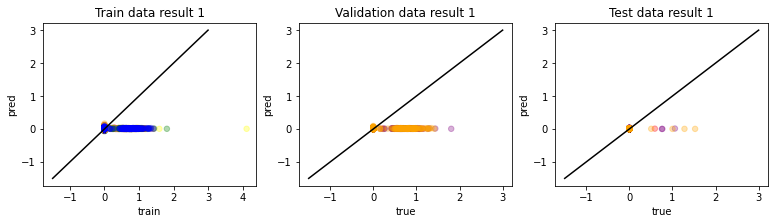

Epoch  11100 Train_loss:  0.07462799  Validation_loss:  0.073246986  Test_loss:  0.08847948
Epoch  11200 Train_loss:  0.07462593  Validation_loss:  0.07324609  Test_loss:  0.08848175
Epoch  11300 Train_loss:  0.074623905  Validation_loss:  0.073245004  Test_loss:  0.0884849
Epoch  11400 Train_loss:  0.07462193  Validation_loss:  0.073243454  Test_loss:  0.08848864
Epoch  11500 Train_loss:  0.074619986  Validation_loss:  0.07324256  Test_loss:  0.08849228
Epoch  11600 Train_loss:  0.074618064  Validation_loss:  0.07324156  Test_loss:  0.08849461
Epoch  11700 Train_loss:  0.074616134  Validation_loss:  0.073240325  Test_loss:  0.08849863
Epoch  11800 Train_loss:  0.074614294  Validation_loss:  0.073239215  Test_loss:  0.08850027
Epoch  11900 Train_loss:  0.07461252  Validation_loss:  0.07323824  Test_loss:  0.088504255
Epoch  12000 Train_loss:  0.07461071  Validation_loss:  0.07323752  Test_loss:  0.08850621


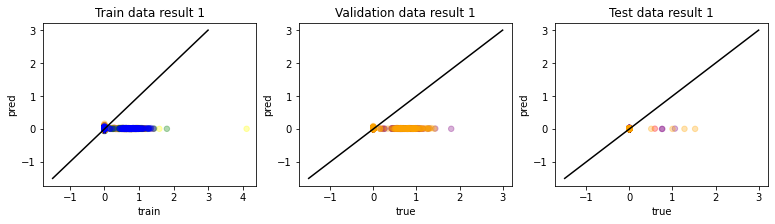

Epoch  12100 Train_loss:  0.074608944  Validation_loss:  0.07323605  Test_loss:  0.08850831
Epoch  12200 Train_loss:  0.07460719  Validation_loss:  0.07323522  Test_loss:  0.0885118
Epoch  12300 Train_loss:  0.07460545  Validation_loss:  0.07323444  Test_loss:  0.08851461
Epoch  12400 Train_loss:  0.07460375  Validation_loss:  0.0732332  Test_loss:  0.08851835
Epoch  12500 Train_loss:  0.0746021  Validation_loss:  0.07323287  Test_loss:  0.08851902
Epoch  12600 Train_loss:  0.07460041  Validation_loss:  0.073232494  Test_loss:  0.088521466
Epoch  12700 Train_loss:  0.07459864  Validation_loss:  0.073231  Test_loss:  0.088526115
Epoch  12800 Train_loss:  0.07459705  Validation_loss:  0.07323021  Test_loss:  0.088528104
Epoch  12900 Train_loss:  0.07459536  Validation_loss:  0.07322942  Test_loss:  0.08853112
Epoch  13000 Train_loss:  0.07459377  Validation_loss:  0.073228836  Test_loss:  0.08853307


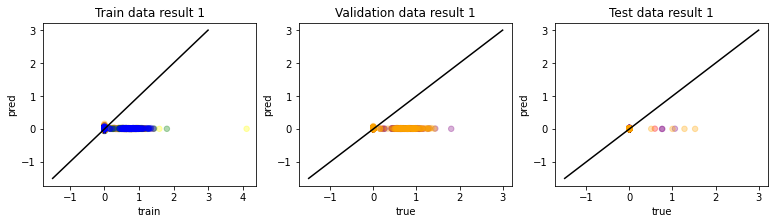

Epoch  13100 Train_loss:  0.07459213  Validation_loss:  0.0732279  Test_loss:  0.08853644
Epoch  13200 Train_loss:  0.07459059  Validation_loss:  0.073227026  Test_loss:  0.088539176
Epoch  13300 Train_loss:  0.07458905  Validation_loss:  0.07322604  Test_loss:  0.08854067
Epoch  13400 Train_loss:  0.07458749  Validation_loss:  0.07322547  Test_loss:  0.08854338
Epoch  13500 Train_loss:  0.07458596  Validation_loss:  0.07322451  Test_loss:  0.08854594
Epoch  13600 Train_loss:  0.07458443  Validation_loss:  0.07322332  Test_loss:  0.088550165
Epoch  13700 Train_loss:  0.07458302  Validation_loss:  0.07322306  Test_loss:  0.088551156
Epoch  13800 Train_loss:  0.074581556  Validation_loss:  0.07322252  Test_loss:  0.08855296
Epoch  13900 Train_loss:  0.07458005  Validation_loss:  0.07322127  Test_loss:  0.088556014
Epoch  14000 Train_loss:  0.07457865  Validation_loss:  0.07322065  Test_loss:  0.08855854


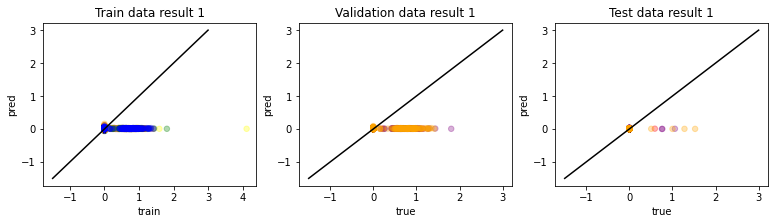

Epoch  14100 Train_loss:  0.074577264  Validation_loss:  0.07322  Test_loss:  0.08856073
Epoch  14200 Train_loss:  0.07457583  Validation_loss:  0.073219106  Test_loss:  0.0885634
Epoch  14300 Train_loss:  0.07457445  Validation_loss:  0.073218256  Test_loss:  0.088565916
Epoch  14400 Train_loss:  0.07457299  Validation_loss:  0.07321742  Test_loss:  0.08856834
Epoch  14500 Train_loss:  0.07457166  Validation_loss:  0.073217  Test_loss:  0.08857066
Epoch  14600 Train_loss:  0.074570335  Validation_loss:  0.07321621  Test_loss:  0.08857212
Epoch  14700 Train_loss:  0.07456903  Validation_loss:  0.07321571  Test_loss:  0.08857381
Epoch  14800 Train_loss:  0.074567735  Validation_loss:  0.073214896  Test_loss:  0.08857726
Epoch  14900 Train_loss:  0.07456645  Validation_loss:  0.07321404  Test_loss:  0.08857965
Epoch  15000 Train_loss:  0.07456519  Validation_loss:  0.07321385  Test_loss:  0.08858043


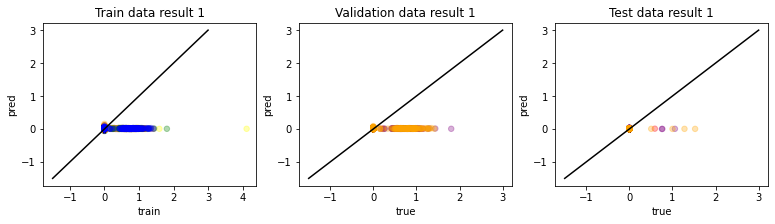

Epoch  15100 Train_loss:  0.07456392  Validation_loss:  0.07321315  Test_loss:  0.088582546
Epoch  15200 Train_loss:  0.074562676  Validation_loss:  0.07321258  Test_loss:  0.08858421
Epoch  15300 Train_loss:  0.07456143  Validation_loss:  0.07321139  Test_loss:  0.088587254
Epoch  15400 Train_loss:  0.07456027  Validation_loss:  0.07321083  Test_loss:  0.08858824
Epoch  15500 Train_loss:  0.07455907  Validation_loss:  0.07321007  Test_loss:  0.088590644
Epoch  15600 Train_loss:  0.07455789  Validation_loss:  0.07320967  Test_loss:  0.08859276
Epoch  15700 Train_loss:  0.074556686  Validation_loss:  0.07320872  Test_loss:  0.08859525
Epoch  15800 Train_loss:  0.07455551  Validation_loss:  0.07320765  Test_loss:  0.088595495
Epoch  15900 Train_loss:  0.07455442  Validation_loss:  0.073207274  Test_loss:  0.088595144
Epoch  16000 Train_loss:  0.07455335  Validation_loss:  0.073206805  Test_loss:  0.08859458


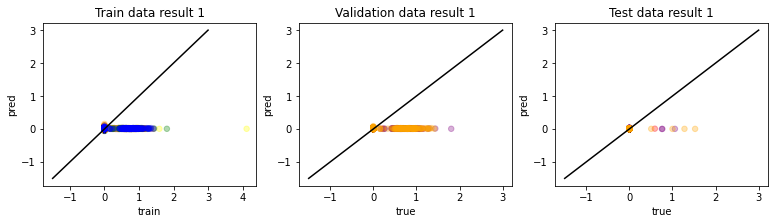

Epoch  16100 Train_loss:  0.074552216  Validation_loss:  0.07320627  Test_loss:  0.08859494
Epoch  16200 Train_loss:  0.07455114  Validation_loss:  0.07320581  Test_loss:  0.08859471
Epoch  16300 Train_loss:  0.07455004  Validation_loss:  0.07320487  Test_loss:  0.08859545
Epoch  16400 Train_loss:  0.074548945  Validation_loss:  0.07320418  Test_loss:  0.08859539
Epoch  16500 Train_loss:  0.07454789  Validation_loss:  0.0732035  Test_loss:  0.08859525
Epoch  16600 Train_loss:  0.074546814  Validation_loss:  0.073202685  Test_loss:  0.088595875
Epoch  16700 Train_loss:  0.07454577  Validation_loss:  0.07320218  Test_loss:  0.088595726
Epoch  16800 Train_loss:  0.07454475  Validation_loss:  0.07320192  Test_loss:  0.08859495
Epoch  16900 Train_loss:  0.07454374  Validation_loss:  0.073201686  Test_loss:  0.08859447
Epoch  17000 Train_loss:  0.07454266  Validation_loss:  0.07320118  Test_loss:  0.088594556


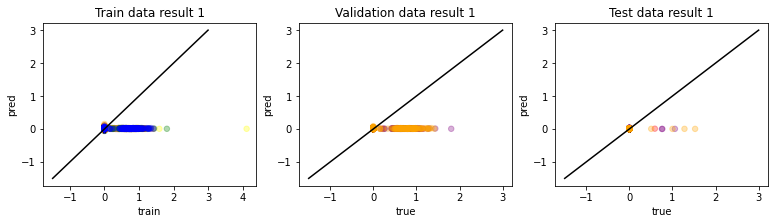

Epoch  17100 Train_loss:  0.07454159  Validation_loss:  0.07320019  Test_loss:  0.088595435
Epoch  17200 Train_loss:  0.07454055  Validation_loss:  0.0731995  Test_loss:  0.08859577
Epoch  17300 Train_loss:  0.074539535  Validation_loss:  0.07319913  Test_loss:  0.08859584
Epoch  17400 Train_loss:  0.074538514  Validation_loss:  0.07319857  Test_loss:  0.08859593
Epoch  17500 Train_loss:  0.07453754  Validation_loss:  0.07319825  Test_loss:  0.0885958
Epoch  17600 Train_loss:  0.07453655  Validation_loss:  0.07319745  Test_loss:  0.0885964
Epoch  17700 Train_loss:  0.074535556  Validation_loss:  0.07319666  Test_loss:  0.08859659
Epoch  17800 Train_loss:  0.07453464  Validation_loss:  0.073195994  Test_loss:  0.08859674
Epoch  17900 Train_loss:  0.07453367  Validation_loss:  0.073195554  Test_loss:  0.0885969
Epoch  18000 Train_loss:  0.07453272  Validation_loss:  0.073195346  Test_loss:  0.08859706


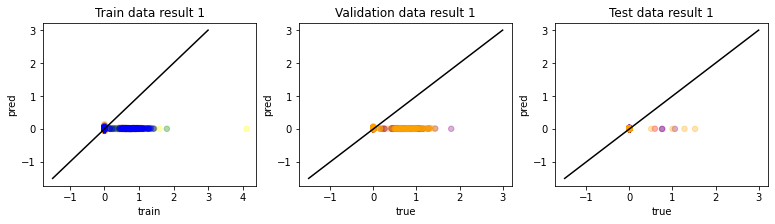

Epoch  18100 Train_loss:  0.07453183  Validation_loss:  0.073195055  Test_loss:  0.08859641
Epoch  18200 Train_loss:  0.07453084  Validation_loss:  0.073194064  Test_loss:  0.088597365
Epoch  18300 Train_loss:  0.0745299  Validation_loss:  0.07319405  Test_loss:  0.08859675
Epoch  18400 Train_loss:  0.074529  Validation_loss:  0.07319305  Test_loss:  0.088597566
Epoch  18500 Train_loss:  0.07452803  Validation_loss:  0.07319229  Test_loss:  0.08859794
Epoch  18600 Train_loss:  0.07452715  Validation_loss:  0.073192134  Test_loss:  0.08859792
Epoch  18700 Train_loss:  0.07452619  Validation_loss:  0.07319178  Test_loss:  0.08859791
Epoch  18800 Train_loss:  0.07452528  Validation_loss:  0.07319147  Test_loss:  0.08859769
Epoch  18900 Train_loss:  0.07452442  Validation_loss:  0.07319095  Test_loss:  0.08859757
Epoch  19000 Train_loss:  0.07452349  Validation_loss:  0.07319034  Test_loss:  0.08859807


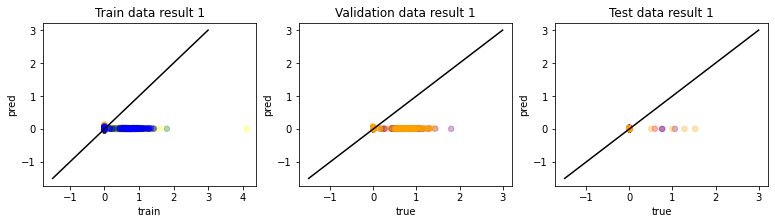

Epoch  19100 Train_loss:  0.074522555  Validation_loss:  0.073190026  Test_loss:  0.08859832
Epoch  19200 Train_loss:  0.07452164  Validation_loss:  0.07318955  Test_loss:  0.08859836
Epoch  19300 Train_loss:  0.07452075  Validation_loss:  0.07318922  Test_loss:  0.08859836
Epoch  19400 Train_loss:  0.07451987  Validation_loss:  0.07318849  Test_loss:  0.08859864
Epoch  19500 Train_loss:  0.07451896  Validation_loss:  0.073188215  Test_loss:  0.088598736
Epoch  19600 Train_loss:  0.07451806  Validation_loss:  0.073187664  Test_loss:  0.08859917
Epoch  19700 Train_loss:  0.0745172  Validation_loss:  0.07318709  Test_loss:  0.088599354
Epoch  19800 Train_loss:  0.07451638  Validation_loss:  0.07318655  Test_loss:  0.08859951
Epoch  19900 Train_loss:  0.0745155  Validation_loss:  0.07318601  Test_loss:  0.088600285


In [40]:
num_epochs = 20000
learning_rate = 0.0001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('No_norm_model_pro_RNA'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Epoch  0 Train_loss:  0.0745155  Validation_loss:  0.07318601  Test_loss:  0.088600285


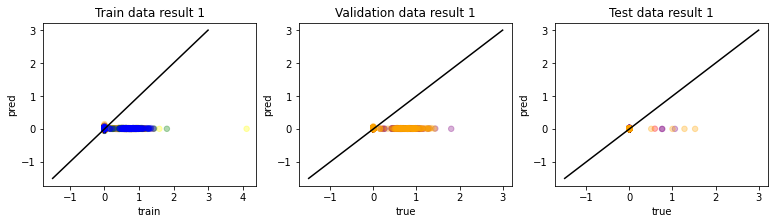

Epoch  100 Train_loss:  0.07451543  Validation_loss:  0.07318589  Test_loss:  0.08859994
Epoch  200 Train_loss:  0.07451534  Validation_loss:  0.07318589  Test_loss:  0.08859994
Epoch  300 Train_loss:  0.07451527  Validation_loss:  0.073185876  Test_loss:  0.088600025
Epoch  400 Train_loss:  0.074515186  Validation_loss:  0.07318593  Test_loss:  0.08859999
Epoch  500 Train_loss:  0.0745151  Validation_loss:  0.07318591  Test_loss:  0.08860005
Epoch  600 Train_loss:  0.07451501  Validation_loss:  0.073185936  Test_loss:  0.08859997
Epoch  700 Train_loss:  0.074514925  Validation_loss:  0.073185764  Test_loss:  0.08859985
Epoch  800 Train_loss:  0.074514866  Validation_loss:  0.07318578  Test_loss:  0.08859993
Epoch  900 Train_loss:  0.07451477  Validation_loss:  0.073185764  Test_loss:  0.08859989
Epoch  1000 Train_loss:  0.07451468  Validation_loss:  0.07318569  Test_loss:  0.08859994


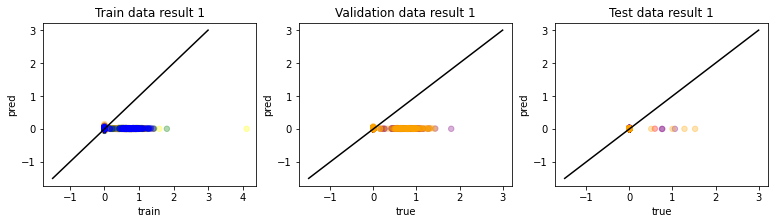

Epoch  1100 Train_loss:  0.0745146  Validation_loss:  0.07318573  Test_loss:  0.08859987
Epoch  1200 Train_loss:  0.0745145  Validation_loss:  0.07318569  Test_loss:  0.088599995
Epoch  1300 Train_loss:  0.07451441  Validation_loss:  0.07318555  Test_loss:  0.088599846
Epoch  1400 Train_loss:  0.07451434  Validation_loss:  0.07318551  Test_loss:  0.08860003
Epoch  1500 Train_loss:  0.07451424  Validation_loss:  0.073185496  Test_loss:  0.08860016
Epoch  1600 Train_loss:  0.074514166  Validation_loss:  0.07318545  Test_loss:  0.08860013
Epoch  1700 Train_loss:  0.07451408  Validation_loss:  0.07318541  Test_loss:  0.08860021
Epoch  1800 Train_loss:  0.074513994  Validation_loss:  0.07318538  Test_loss:  0.088600226
Epoch  1900 Train_loss:  0.07451391  Validation_loss:  0.07318522  Test_loss:  0.08860005
Epoch  2000 Train_loss:  0.07451382  Validation_loss:  0.07318518  Test_loss:  0.08860011


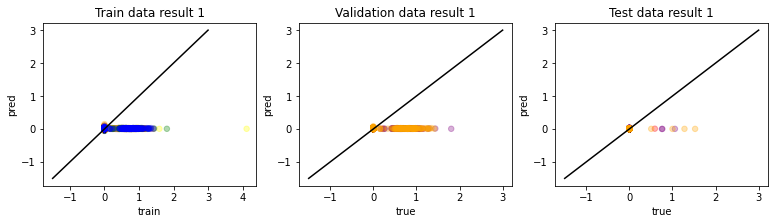

Epoch  2100 Train_loss:  0.07451374  Validation_loss:  0.07318519  Test_loss:  0.08860007
Epoch  2200 Train_loss:  0.07451364  Validation_loss:  0.07318516  Test_loss:  0.088600054
Epoch  2300 Train_loss:  0.074513584  Validation_loss:  0.07318512  Test_loss:  0.08860034
Epoch  2400 Train_loss:  0.0745135  Validation_loss:  0.07318517  Test_loss:  0.08860022
Epoch  2500 Train_loss:  0.07451342  Validation_loss:  0.07318498  Test_loss:  0.08860011
Epoch  2600 Train_loss:  0.07451333  Validation_loss:  0.073184915  Test_loss:  0.08860022
Epoch  2700 Train_loss:  0.07451325  Validation_loss:  0.0731849  Test_loss:  0.08860026
Epoch  2800 Train_loss:  0.074513145  Validation_loss:  0.073184885  Test_loss:  0.088600434
Epoch  2900 Train_loss:  0.07451306  Validation_loss:  0.07318485  Test_loss:  0.08860063
Epoch  3000 Train_loss:  0.074512966  Validation_loss:  0.07318478  Test_loss:  0.088600844


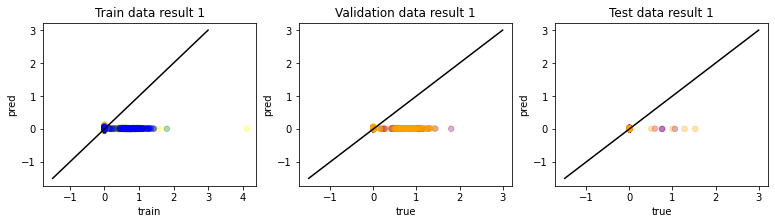

Epoch  3100 Train_loss:  0.0745129  Validation_loss:  0.073184595  Test_loss:  0.08860066
Epoch  3200 Train_loss:  0.074512824  Validation_loss:  0.073184565  Test_loss:  0.08860067
Epoch  3300 Train_loss:  0.07451271  Validation_loss:  0.07318454  Test_loss:  0.08860075
Epoch  3400 Train_loss:  0.07451263  Validation_loss:  0.073184505  Test_loss:  0.08860082
Epoch  3500 Train_loss:  0.07451257  Validation_loss:  0.07318455  Test_loss:  0.08860075
Epoch  3600 Train_loss:  0.0745125  Validation_loss:  0.073184334  Test_loss:  0.08860052
Epoch  3700 Train_loss:  0.0745124  Validation_loss:  0.073184356  Test_loss:  0.08860055
Epoch  3800 Train_loss:  0.07451231  Validation_loss:  0.07318435  Test_loss:  0.08860058
Epoch  3900 Train_loss:  0.074512236  Validation_loss:  0.073184334  Test_loss:  0.08860063
Epoch  4000 Train_loss:  0.07451213  Validation_loss:  0.073184334  Test_loss:  0.08860071


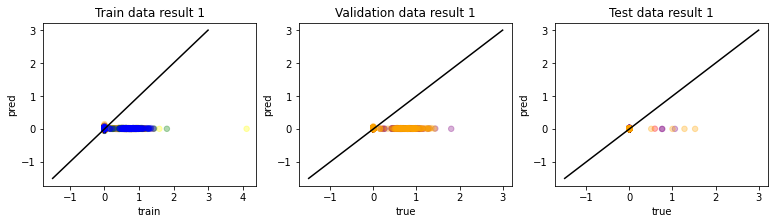

Epoch  4100 Train_loss:  0.074512064  Validation_loss:  0.073184334  Test_loss:  0.08860064
Epoch  4200 Train_loss:  0.074512005  Validation_loss:  0.073184185  Test_loss:  0.0886006
Epoch  4300 Train_loss:  0.07451191  Validation_loss:  0.07318416  Test_loss:  0.088600606
Epoch  4400 Train_loss:  0.07451182  Validation_loss:  0.073184155  Test_loss:  0.08860064
Epoch  4500 Train_loss:  0.07451173  Validation_loss:  0.073184095  Test_loss:  0.08860088
Epoch  4600 Train_loss:  0.07451164  Validation_loss:  0.073184066  Test_loss:  0.088600904
Epoch  4700 Train_loss:  0.07451156  Validation_loss:  0.07318403  Test_loss:  0.08860105
Epoch  4800 Train_loss:  0.07451146  Validation_loss:  0.073183835  Test_loss:  0.088600874
Epoch  4900 Train_loss:  0.07451138  Validation_loss:  0.073183745  Test_loss:  0.08860104
Epoch  5000 Train_loss:  0.0745113  Validation_loss:  0.07318374  Test_loss:  0.08860114


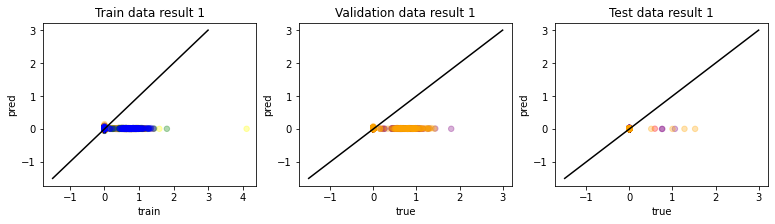

Epoch  5100 Train_loss:  0.0745112  Validation_loss:  0.0731837  Test_loss:  0.08860128
Epoch  5200 Train_loss:  0.07451112  Validation_loss:  0.073183686  Test_loss:  0.088601336
Epoch  5300 Train_loss:  0.07451105  Validation_loss:  0.07318371  Test_loss:  0.08860145
Epoch  5400 Train_loss:  0.07451096  Validation_loss:  0.07318351  Test_loss:  0.08860126
Epoch  5500 Train_loss:  0.07451087  Validation_loss:  0.073183455  Test_loss:  0.088601336
Epoch  5600 Train_loss:  0.074510805  Validation_loss:  0.07318346  Test_loss:  0.08860135
Epoch  5700 Train_loss:  0.07451071  Validation_loss:  0.07318344  Test_loss:  0.08860138
Epoch  5800 Train_loss:  0.07451063  Validation_loss:  0.073183425  Test_loss:  0.08860133
Epoch  5900 Train_loss:  0.07451051  Validation_loss:  0.07318344  Test_loss:  0.0886014
Epoch  6000 Train_loss:  0.07451043  Validation_loss:  0.073183306  Test_loss:  0.088601254


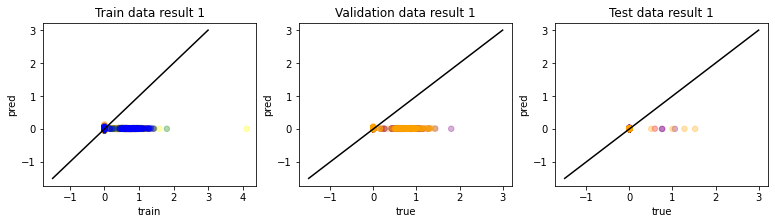

Epoch  6100 Train_loss:  0.074510366  Validation_loss:  0.07318331  Test_loss:  0.088601165
Epoch  6200 Train_loss:  0.07451027  Validation_loss:  0.07318328  Test_loss:  0.08860118
Epoch  6300 Train_loss:  0.07451017  Validation_loss:  0.07318321  Test_loss:  0.088601336
Epoch  6400 Train_loss:  0.07451009  Validation_loss:  0.07318327  Test_loss:  0.088601336
Epoch  6500 Train_loss:  0.07451001  Validation_loss:  0.07318327  Test_loss:  0.08860139
Epoch  6600 Train_loss:  0.07450991  Validation_loss:  0.07318311  Test_loss:  0.08860119
Epoch  6700 Train_loss:  0.07450982  Validation_loss:  0.073183104  Test_loss:  0.08860126
Epoch  6800 Train_loss:  0.074509725  Validation_loss:  0.0731831  Test_loss:  0.088601306
Epoch  6900 Train_loss:  0.07450965  Validation_loss:  0.07318308  Test_loss:  0.08860136
Epoch  7000 Train_loss:  0.07450956  Validation_loss:  0.07318308  Test_loss:  0.08860154


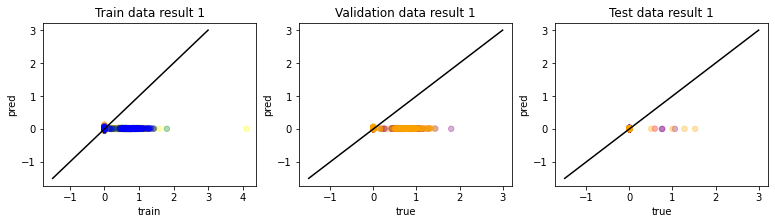

Epoch  7100 Train_loss:  0.07450948  Validation_loss:  0.073183075  Test_loss:  0.08860146
Epoch  7200 Train_loss:  0.07450938  Validation_loss:  0.07318292  Test_loss:  0.088601284
Epoch  7300 Train_loss:  0.074509315  Validation_loss:  0.07318298  Test_loss:  0.08860129
Epoch  7400 Train_loss:  0.074509226  Validation_loss:  0.07318292  Test_loss:  0.08860158
Epoch  7500 Train_loss:  0.07450912  Validation_loss:  0.073182814  Test_loss:  0.088601746
Epoch  7600 Train_loss:  0.07450905  Validation_loss:  0.073182896  Test_loss:  0.08860171
Epoch  7700 Train_loss:  0.07450896  Validation_loss:  0.07318286  Test_loss:  0.08860178
Epoch  7800 Train_loss:  0.07450888  Validation_loss:  0.07318267  Test_loss:  0.088601604
Epoch  7900 Train_loss:  0.07450879  Validation_loss:  0.073182665  Test_loss:  0.0886016
Epoch  8000 Train_loss:  0.07450872  Validation_loss:  0.073182724  Test_loss:  0.08860148


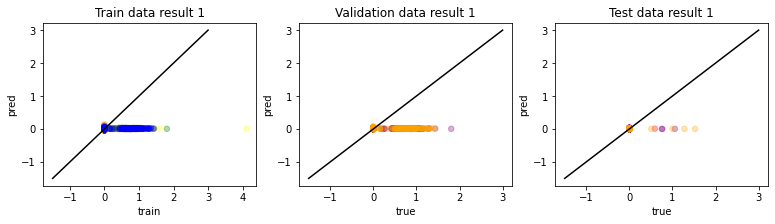

Epoch  8100 Train_loss:  0.07450862  Validation_loss:  0.07318267  Test_loss:  0.08860167
Epoch  8200 Train_loss:  0.07450853  Validation_loss:  0.07318263  Test_loss:  0.08860176
Epoch  8300 Train_loss:  0.07450845  Validation_loss:  0.07318245  Test_loss:  0.08860163
Epoch  8400 Train_loss:  0.07450838  Validation_loss:  0.07318243  Test_loss:  0.08860162
Epoch  8500 Train_loss:  0.07450828  Validation_loss:  0.07318242  Test_loss:  0.088601656
Epoch  8600 Train_loss:  0.07450819  Validation_loss:  0.07318238  Test_loss:  0.08860185
Epoch  8700 Train_loss:  0.074508116  Validation_loss:  0.0731824  Test_loss:  0.08860192
Epoch  8800 Train_loss:  0.07450802  Validation_loss:  0.07318232  Test_loss:  0.088602014
Epoch  8900 Train_loss:  0.074507944  Validation_loss:  0.07318223  Test_loss:  0.08860176
Epoch  9000 Train_loss:  0.074507855  Validation_loss:  0.0731822  Test_loss:  0.088601805


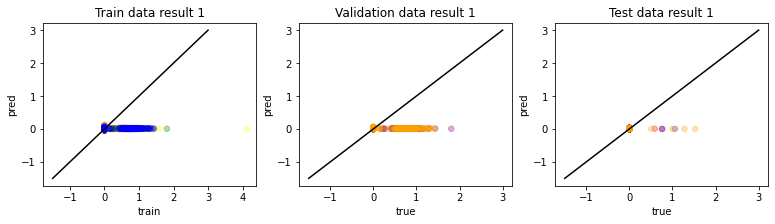

Epoch  9100 Train_loss:  0.074507765  Validation_loss:  0.073182225  Test_loss:  0.088601895
Epoch  9200 Train_loss:  0.07450769  Validation_loss:  0.07318215  Test_loss:  0.08860193
Epoch  9300 Train_loss:  0.0745076  Validation_loss:  0.07318216  Test_loss:  0.08860204
Epoch  9400 Train_loss:  0.07450751  Validation_loss:  0.073182106  Test_loss:  0.088602215
Epoch  9500 Train_loss:  0.07450744  Validation_loss:  0.073181964  Test_loss:  0.08860214
Epoch  9600 Train_loss:  0.07450733  Validation_loss:  0.073181935  Test_loss:  0.08860217
Epoch  9700 Train_loss:  0.07450726  Validation_loss:  0.07318195  Test_loss:  0.08860218
Epoch  9800 Train_loss:  0.07450718  Validation_loss:  0.07318188  Test_loss:  0.08860229
Epoch  9900 Train_loss:  0.07450709  Validation_loss:  0.07318181  Test_loss:  0.08860244
Epoch  10000 Train_loss:  0.07450699  Validation_loss:  0.073181786  Test_loss:  0.088602476


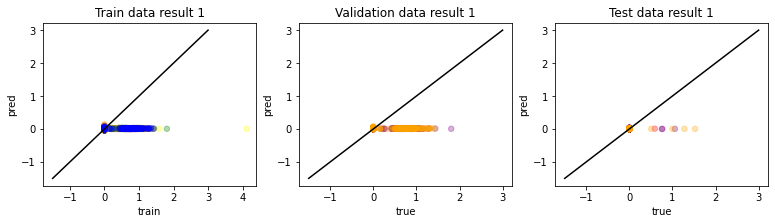

Epoch  10100 Train_loss:  0.07450691  Validation_loss:  0.0731816  Test_loss:  0.088602245
Epoch  10200 Train_loss:  0.074506804  Validation_loss:  0.07318154  Test_loss:  0.08860241
Epoch  10300 Train_loss:  0.07450671  Validation_loss:  0.07318146  Test_loss:  0.088602565
Epoch  10400 Train_loss:  0.07450666  Validation_loss:  0.07318155  Test_loss:  0.08860254
Epoch  10500 Train_loss:  0.07450656  Validation_loss:  0.07318147  Test_loss:  0.0886027
Epoch  10600 Train_loss:  0.07450645  Validation_loss:  0.07318147  Test_loss:  0.0886026
Epoch  10700 Train_loss:  0.07450638  Validation_loss:  0.073181294  Test_loss:  0.0886025
Epoch  10800 Train_loss:  0.074506275  Validation_loss:  0.07318131  Test_loss:  0.08860255
Epoch  10900 Train_loss:  0.07450618  Validation_loss:  0.073181316  Test_loss:  0.08860257
Epoch  11000 Train_loss:  0.074506104  Validation_loss:  0.07318133  Test_loss:  0.08860271


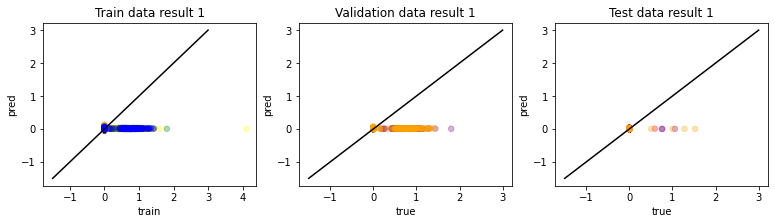

Epoch  11100 Train_loss:  0.074506015  Validation_loss:  0.07318132  Test_loss:  0.08860276
Epoch  11200 Train_loss:  0.07450592  Validation_loss:  0.07318135  Test_loss:  0.08860288
Epoch  11300 Train_loss:  0.07450583  Validation_loss:  0.07318124  Test_loss:  0.088602684
Epoch  11400 Train_loss:  0.07450574  Validation_loss:  0.07318117  Test_loss:  0.08860272
Epoch  11500 Train_loss:  0.07450564  Validation_loss:  0.07318117  Test_loss:  0.088602915
Epoch  11600 Train_loss:  0.07450556  Validation_loss:  0.07318119  Test_loss:  0.08860296
Epoch  11700 Train_loss:  0.074505456  Validation_loss:  0.07318114  Test_loss:  0.088603064
Epoch  11800 Train_loss:  0.074505374  Validation_loss:  0.07318111  Test_loss:  0.088603064
Epoch  11900 Train_loss:  0.0745053  Validation_loss:  0.07318094  Test_loss:  0.08860295
Epoch  12000 Train_loss:  0.07450519  Validation_loss:  0.07318093  Test_loss:  0.088603005


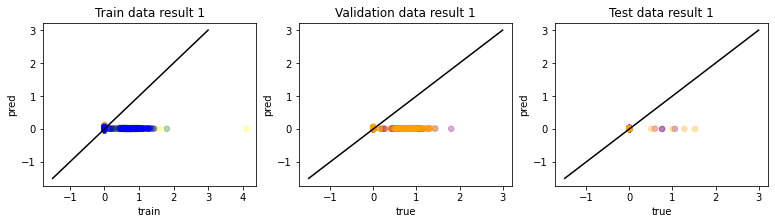

Epoch  12100 Train_loss:  0.074505106  Validation_loss:  0.07318088  Test_loss:  0.08860304
Epoch  12200 Train_loss:  0.07450503  Validation_loss:  0.07318086  Test_loss:  0.08860312
Epoch  12300 Train_loss:  0.07450492  Validation_loss:  0.07318084  Test_loss:  0.088603176
Epoch  12400 Train_loss:  0.074504815  Validation_loss:  0.07318075  Test_loss:  0.088603415
Epoch  12500 Train_loss:  0.07450474  Validation_loss:  0.07318064  Test_loss:  0.08860307
Epoch  12600 Train_loss:  0.07450465  Validation_loss:  0.07318073  Test_loss:  0.088603
Epoch  12700 Train_loss:  0.07450453  Validation_loss:  0.073180646  Test_loss:  0.088603295
Epoch  12800 Train_loss:  0.07450447  Validation_loss:  0.073180676  Test_loss:  0.08860323
Epoch  12900 Train_loss:  0.07450435  Validation_loss:  0.07318067  Test_loss:  0.0886033
Epoch  13000 Train_loss:  0.074504286  Validation_loss:  0.07318067  Test_loss:  0.088603474


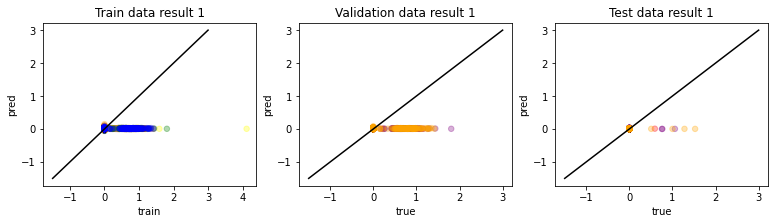

Epoch  13100 Train_loss:  0.07450418  Validation_loss:  0.073180534  Test_loss:  0.088603266
Epoch  13200 Train_loss:  0.07450411  Validation_loss:  0.07318051  Test_loss:  0.08860326
Epoch  13300 Train_loss:  0.074503995  Validation_loss:  0.07318045  Test_loss:  0.08860333
Epoch  13400 Train_loss:  0.074503906  Validation_loss:  0.073180474  Test_loss:  0.08860341
Epoch  13500 Train_loss:  0.07450381  Validation_loss:  0.07318044  Test_loss:  0.088603616
Epoch  13600 Train_loss:  0.074503735  Validation_loss:  0.073180415  Test_loss:  0.088603705
Epoch  13700 Train_loss:  0.07450362  Validation_loss:  0.07318023  Test_loss:  0.0886035
Epoch  13800 Train_loss:  0.074503556  Validation_loss:  0.073180266  Test_loss:  0.08860342
Epoch  13900 Train_loss:  0.07450346  Validation_loss:  0.073180236  Test_loss:  0.08860347
Epoch  14000 Train_loss:  0.07450336  Validation_loss:  0.073180206  Test_loss:  0.08860349


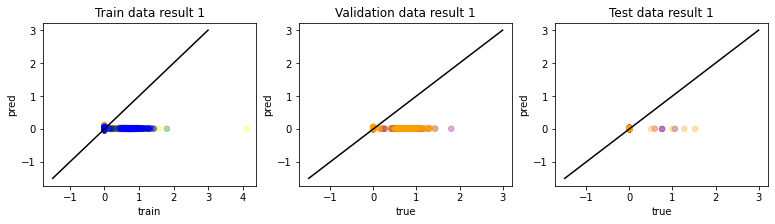

Epoch  14100 Train_loss:  0.07450326  Validation_loss:  0.07318018  Test_loss:  0.088603534
Epoch  14200 Train_loss:  0.074503176  Validation_loss:  0.073180184  Test_loss:  0.08860363
Epoch  14300 Train_loss:  0.074503094  Validation_loss:  0.07318  Test_loss:  0.088603474
Epoch  14400 Train_loss:  0.07450299  Validation_loss:  0.07317993  Test_loss:  0.08860376
Epoch  14500 Train_loss:  0.0745029  Validation_loss:  0.07317994  Test_loss:  0.088603824
Epoch  14600 Train_loss:  0.07450282  Validation_loss:  0.07317995  Test_loss:  0.08860373
Epoch  14700 Train_loss:  0.07450271  Validation_loss:  0.07317993  Test_loss:  0.08860378
Epoch  14800 Train_loss:  0.07450264  Validation_loss:  0.07317993  Test_loss:  0.08860404
Epoch  14900 Train_loss:  0.074502535  Validation_loss:  0.07317974  Test_loss:  0.08860385
Epoch  15000 Train_loss:  0.07450244  Validation_loss:  0.073179744  Test_loss:  0.088603996


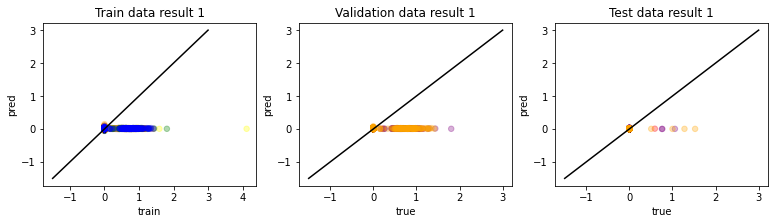

Epoch  15100 Train_loss:  0.07450236  Validation_loss:  0.073179714  Test_loss:  0.08860405
Epoch  15200 Train_loss:  0.074502274  Validation_loss:  0.07317976  Test_loss:  0.08860393
Epoch  15300 Train_loss:  0.07450219  Validation_loss:  0.07317974  Test_loss:  0.088604026
Epoch  15400 Train_loss:  0.07450208  Validation_loss:  0.07317969  Test_loss:  0.08860409
Epoch  15500 Train_loss:  0.074502006  Validation_loss:  0.07317952  Test_loss:  0.0886042
Epoch  15600 Train_loss:  0.07450192  Validation_loss:  0.07317952  Test_loss:  0.08860424
Epoch  15700 Train_loss:  0.07450182  Validation_loss:  0.07317947  Test_loss:  0.0886044
Epoch  15800 Train_loss:  0.07450172  Validation_loss:  0.0731794  Test_loss:  0.0886046
Epoch  15900 Train_loss:  0.074501656  Validation_loss:  0.07317939  Test_loss:  0.088604644
Epoch  16000 Train_loss:  0.074501544  Validation_loss:  0.07317934  Test_loss:  0.08860464


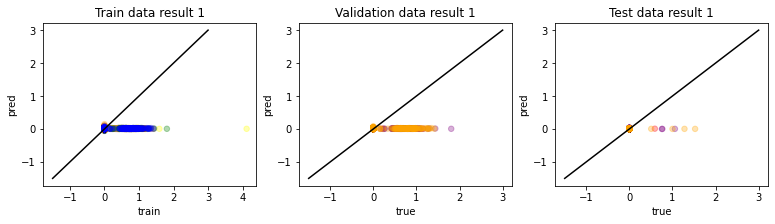

Epoch  16100 Train_loss:  0.07450148  Validation_loss:  0.07317919  Test_loss:  0.088604465
Epoch  16200 Train_loss:  0.074501395  Validation_loss:  0.07317921  Test_loss:  0.088604525
Epoch  16300 Train_loss:  0.07450128  Validation_loss:  0.073179156  Test_loss:  0.08860464
Epoch  16400 Train_loss:  0.0745012  Validation_loss:  0.07317911  Test_loss:  0.08860474
Epoch  16500 Train_loss:  0.07450111  Validation_loss:  0.07317908  Test_loss:  0.08860478
Epoch  16600 Train_loss:  0.07450103  Validation_loss:  0.07317905  Test_loss:  0.088604815
Epoch  16700 Train_loss:  0.07450095  Validation_loss:  0.07317885  Test_loss:  0.08860483
Epoch  16800 Train_loss:  0.074500866  Validation_loss:  0.07317886  Test_loss:  0.088604905
Epoch  16900 Train_loss:  0.07450077  Validation_loss:  0.07317891  Test_loss:  0.08860482
Epoch  17000 Train_loss:  0.07450067  Validation_loss:  0.073178895  Test_loss:  0.08860501


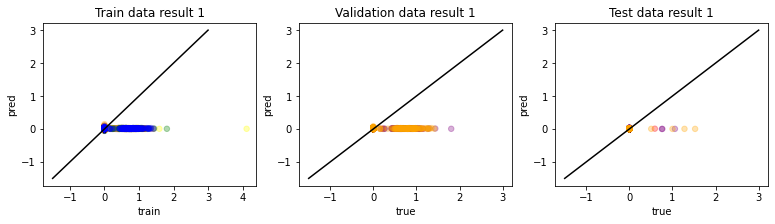

Epoch  17100 Train_loss:  0.07450057  Validation_loss:  0.07317885  Test_loss:  0.08860509
Epoch  17200 Train_loss:  0.07450051  Validation_loss:  0.07317884  Test_loss:  0.088605225
Epoch  17300 Train_loss:  0.074500404  Validation_loss:  0.07317865  Test_loss:  0.08860502
Epoch  17400 Train_loss:  0.07450032  Validation_loss:  0.073178634  Test_loss:  0.08860505
Epoch  17500 Train_loss:  0.07450024  Validation_loss:  0.07317865  Test_loss:  0.08860514
Epoch  17600 Train_loss:  0.07450015  Validation_loss:  0.073178604  Test_loss:  0.08860533
Epoch  17700 Train_loss:  0.07450005  Validation_loss:  0.07317856  Test_loss:  0.08860542
Epoch  17800 Train_loss:  0.074499965  Validation_loss:  0.07317851  Test_loss:  0.088605456
Epoch  17900 Train_loss:  0.074499875  Validation_loss:  0.07317832  Test_loss:  0.08860538
Epoch  18000 Train_loss:  0.07449979  Validation_loss:  0.07317833  Test_loss:  0.08860526


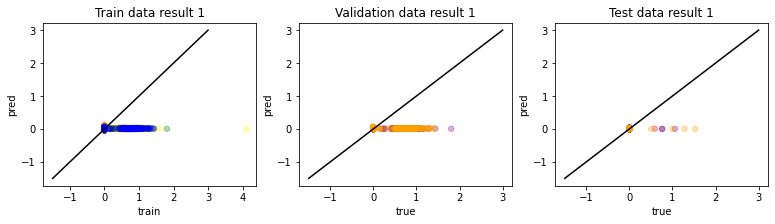

Epoch  18100 Train_loss:  0.074499704  Validation_loss:  0.07317834  Test_loss:  0.08860536
Epoch  18200 Train_loss:  0.0744996  Validation_loss:  0.07317828  Test_loss:  0.088605404
Epoch  18300 Train_loss:  0.07449951  Validation_loss:  0.073178336  Test_loss:  0.088605456
Epoch  18400 Train_loss:  0.074499436  Validation_loss:  0.07317828  Test_loss:  0.088605635
Epoch  18500 Train_loss:  0.07449933  Validation_loss:  0.07317808  Test_loss:  0.08860551
Epoch  18600 Train_loss:  0.074499264  Validation_loss:  0.07317806  Test_loss:  0.08860573
Epoch  18700 Train_loss:  0.07449916  Validation_loss:  0.07317805  Test_loss:  0.08860578
Epoch  18800 Train_loss:  0.074499056  Validation_loss:  0.07317804  Test_loss:  0.08860589
Epoch  18900 Train_loss:  0.07449898  Validation_loss:  0.07317801  Test_loss:  0.088606015
Epoch  19000 Train_loss:  0.0744989  Validation_loss:  0.07317804  Test_loss:  0.088605985


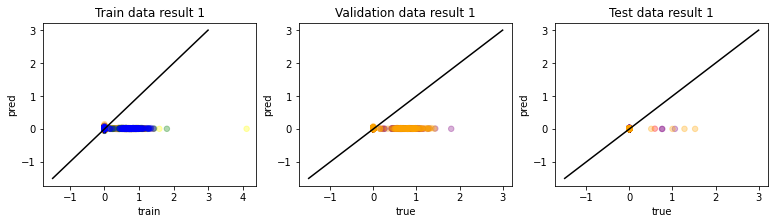

Epoch  19100 Train_loss:  0.0744988  Validation_loss:  0.07317786  Test_loss:  0.08860585
Epoch  19200 Train_loss:  0.07449873  Validation_loss:  0.07317787  Test_loss:  0.088605925
Epoch  19300 Train_loss:  0.07449862  Validation_loss:  0.07317784  Test_loss:  0.08860593
Epoch  19400 Train_loss:  0.074498534  Validation_loss:  0.0731778  Test_loss:  0.08860612
Epoch  19500 Train_loss:  0.07449846  Validation_loss:  0.073177844  Test_loss:  0.08860602
Epoch  19600 Train_loss:  0.07449836  Validation_loss:  0.07317782  Test_loss:  0.08860607
Epoch  19700 Train_loss:  0.07449828  Validation_loss:  0.07317762  Test_loss:  0.08860588
Epoch  19800 Train_loss:  0.0744982  Validation_loss:  0.0731776  Test_loss:  0.08860605
Epoch  19900 Train_loss:  0.07449812  Validation_loss:  0.07317756  Test_loss:  0.08860621


In [41]:
num_epochs = 20000
learning_rate = 0.00001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
model.load_state_dict(torch.load('No_norm_model_pro_RNA'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)